In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
# Load the dataset
df = pd.read_csv('Fraud.csv')

# Check for missing values
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [71]:
# Handling categorical data
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [72]:
# Count the number of fraudulent and non-fraudulent transactions
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [73]:
# Function to calculate VIF
def calculate_vif(data):
    vif = pd.DataFrame()
    vif['Feature'] = data.columns
    vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif

# Initial VIF calculation, drop columns not used in VIF calculation
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

# Ensure all columns are of numeric type
X = X.astype(float)

vif_data = calculate_vif(X)
print(vif_data)

# Remove features with high VIF (VIF > 10)
while vif_data['VIF'].max() > 10:
    feature_to_remove = vif_data.sort_values('VIF', ascending=False)['Feature'].iloc[0]
    print(f'Removing {feature_to_remove} with VIF {vif_data["VIF"].max()}')
    X = X.drop(columns=[feature_to_remove])
    vif_data = calculate_vif(X)

# Final VIF calculation
print(vif_data)


          Feature         VIF
0            step    3.008676
1          amount    4.213518
2   oldbalanceOrg  502.775340
3  newbalanceOrig  508.200245
4  oldbalanceDest   72.373007
5  newbalanceDest   84.022951
6   type_CASH_OUT    1.870070
7      type_DEBIT    1.016117
8    type_PAYMENT    1.764562
9   type_TRANSFER    1.406324
Removing newbalanceOrig with VIF 508.20024535438847
Removing newbalanceDest with VIF 83.26145955326068
          Feature       VIF
0            step  2.741821
1          amount  1.359233
2   oldbalanceOrg  1.145940
3  oldbalanceDest  1.241039
4   type_CASH_OUT  1.721125
5      type_DEBIT  1.014211
6    type_PAYMENT  1.687923
7   type_TRANSFER  1.366268


In [74]:
# Check if the dataset is balanced
total_transactions = len(df)
fraudulent_transactions = fraud_counts[1]
non_fraudulent_transactions = fraud_counts[0]

print(f"Total transactions: {total_transactions}")
print(f"Fraudulent transactions: {fraudulent_transactions}")
print(f"Non-fraudulent transactions: {non_fraudulent_transactions}")

# Calculate the percentage of fraudulent transactions
fraud_percentage = (fraudulent_transactions / total_transactions) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")

# Check if the dataset is balanced
if fraudulent_transactions / total_transactions < 0.4:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

Total transactions: 6362620
Fraudulent transactions: 8213
Non-fraudulent transactions: 6354407
Percentage of fraudulent transactions: 0.13%
The dataset is imbalanced.


In [75]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# Sample data (replace this with your dataset)
# X_train: Features, y_train: Target labels
X_train = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
y_train = np.array([0, 0, 0, 1, 1])

# Before balancing
print("Before balancing:")
print(pd.Series(y_train).value_counts())

# Balancing using RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

# After balancing
print("\nAfter balancing (oversampling):")
print(pd.Series(y_resampled).value_counts())

# Balancing using RandomUnderSampler
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

# After balancing
print("\nAfter balancing (undersampling):")
print(pd.Series(y_resampled).value_counts())

Before balancing:
0    3
1    2
Name: count, dtype: int64

After balancing (oversampling):
0    3
1    3
Name: count, dtype: int64

After balancing (undersampling):
0    2
1    2
Name: count, dtype: int64


In [76]:
# Normalization
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
)

# Remove outliers using IQR method
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out the outliers
df = df[~((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR)))]

In [77]:
# After filtering, redefine X and y
y = df['isFraud']
X = df.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)


In [78]:
# Ensure there are no remaining object or categorical types
print(X.dtypes)

step                int64
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
type_CASH_OUT        bool
type_DEBIT           bool
type_PAYMENT         bool
type_TRANSFER        bool
dtype: object


In [79]:
# Prepare data for modeling
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [80]:
# Ensure there are no NaN values
print(X_train.isnull().sum())
print(X_test.isnull().sum())
print(y_train.isnull().sum())
print(y_test.isnull().sum())

step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64
step              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
type_CASH_OUT     0
type_DEBIT        0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64
0
0


In [81]:
# Build and train the logistic regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

c:\Users\Pranav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

[[1678906  127149]
 [      8    1300]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1806055
           1       0.01      0.99      0.02      1308

    accuracy                           0.93   1807363
   macro avg       0.51      0.96      0.49   1807363
weighted avg       1.00      0.93      0.96   1807363

Accuracy: 0.9296450132043204
ROC-AUC Score: 0.9922464139213928


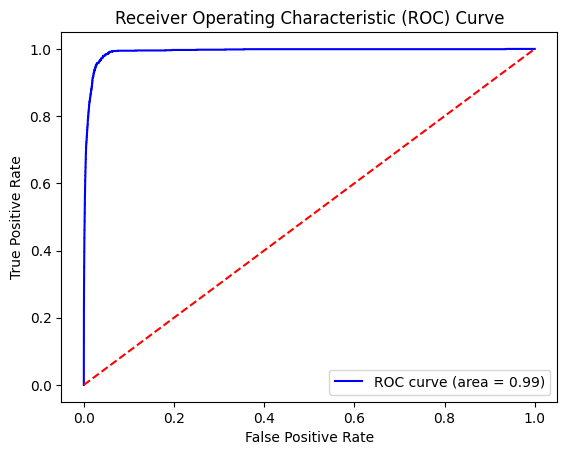

In [82]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Classification Report
print(classification_report(y_test, y_pred))

# Accuracy Score
print("Accuracy:", accuracy_score(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# Plotting the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
